# Multi Layer Perceptron Classifier

Implementing a neural network using numpy to classify images of handrawn digits in MNIST dataset. The network will be a simple multilayer perceptron with 2 hidden layers.

First we import the packages we need for the notebook. Numpy to build the network, matplotlib to provide any plots and tensorflow to easily load in the MNIST dataset.

In [284]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Next we load in the MNIST dataset and take care of any data preprocessing. This includes normalising the pixel values of the images and converting the labels from integer values to one hot encoding.

In [285]:
# Load in MNIST data, generating train and test splits
dataset = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = dataset.load_data()

# Normalise Inputs (Images) for Training and Test Data
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

# Convert labels to one hot encoding
y_train_one_hot = np.zeros((y_train.size, y_train.max() + 1))
y_train_one_hot[np.arange(y_train.size), y_train] = 1

In the next section we write cost function and the activation functions that will be used in the network. We use a categorical cross entropy cost function to compute a loss value for the network. We have chosen to use sigmoid functions on the outputs of the hidden layers and a softmax function on the output layer.

Additionally, we need to implement the derivative of the sigmoid function to facilitate backpropagation of error through the network during training. There is no reason to directly compute the derivative of the softmax function due to a nice mathematical property we can use to simplify the process:

In [286]:
def flatten_input(x):
    """ Flatten 2D image to one dimension so that it fits dense layer """
    flattened_input = x.reshape((x.shape[0], -1)).swapaxes(0,1)
    return flattened_input

def sigmoid(x):
    """ Sigmoid/Logistic Function """
    return 1 / (1 + np.exp(x))

def sigmoid_derivative(x):
    """ Derivative of Sigmoid Function """
    return sigmoid(x) * (1 - sigmoid(x))

def relu(Z):
    """ Rectified Linear Unit - Activation Function """
    return np.maximum(Z, 0)

def relu_derivative(Z):
    """ Derivative of ReLU function """
    return Z > 0

def softmax(x: np.ndarray):
    """ Softmax function for Output Vectors """
    # First, Values are shifted to reduce chance of generating NaN values
    x = x - np.max(x)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)

def cost_function(y_hat: np.ndarray, y: np.ndarray):
    """
    Categorical Cross Entropy Cost Function for a Batch of Samples
    y_hat: the predictions made by the network for input x
        y: the true value of the label corresponding to input x
    """
    losses = []
    for t, p in zip(y, y_hat):
        loss = -np.sum(t * np.log(p))
        losses.append(loss)
    return np.sum(losses)/len(losses)

Now we can define some of the processes that will occur in our training loop.

In [287]:
def initialise_parameters(input_size: int):
    """ Initialise weight and bias vectors with random values"""
    # First initialise weights
    # Dim1 = size of previous layer
    # Dim2 = size of current layer
    w1 = np.random.rand(128, input_size) - 0.5
    w2 = np.random.rand(128, 128) - 0.5
    w3 = np.random.rand(10, 128) - 0.5

    # Initialising biases
    # Dim is size of layer
    b1 = np.random.rand(128, 1) - 0.5
    b2 = np.random.rand(128, 1) - 0.5
    b3 = np.random.rand(10, 1) - 0.5

    return w1, b1, w2, b2, w3, b3

def feed_forward(x_data: np.ndarray, parameters: list[np.ndarray]) -> np.ndarray:
    """ Feed input forward through the network """
    # Unpack parameters
    w1, b1, w2, b2, w3, b3 = parameters
    # Flatten 2D image to 1D
    x_data = flatten_input(x_data)
    # Pass through hidden layer 1
    z1 = w1.dot(x_data) + b1
    a1 = relu(z1)
    # Pass through hidden layer 2
    z2 = w2.dot(a1) + b2
    a2 = relu(z2)
    # Pass through output layer
    z3 = w3.dot(a2) + b3
    a3 = softmax(z3)
    # (a3 is the output of the network)
    # Keep track of inputs and outputs to each layer for backpropagation
    layer_io = [z1, a1, z2, a2, z3, a3]
    return layer_io

def back_propagate(
        x: np.ndarray,
        y: np.ndarray, 
        layer_io: list[np.ndarray],
        parameters: list[np.ndarray]
    ):
    """
    Backpropagate through the network starting from the network prediction.
    Returns the gradients for each layer of the network.
    """
    # Unpack weight/bias params and layer inputs/outputs
    z1, a1, z2, a2, z3, a3 = layer_io
    w1, b1, w2, b2, w3, b3 = parameters
    x = flatten_input(x)
    # Check batch size so we can get average gradients
    batch_size = y.shape[0]
    # Backpropagation Algorithm
    # Output Layer
    dz3 = a3 - y # y_hat == a3
    dw3 = (1/batch_size) * dz3.dot(a2.T)
    db3 = (1/batch_size) * np.sum(dz3, axis=1).reshape(b3.size, 1)
    # Second Hidden Layer
    dz2 = w3.T.dot(dz3) * relu_derivative(z2)
    dw2 = (1/batch_size) * dz2.dot(a1.T)
    db2 = (1/batch_size) * np.sum(dz2, axis=1).reshape(b2.size, 1)
    # First Hidden Layer
    dz1 = w2.T.dot(dz2) * relu_derivative(z1)
    dw1 = (1/batch_size) * dz1.dot(x.T)
    db1 = (1/batch_size) * np.sum(dz1, axis=1).reshape(b1.size, 1)
    return dw1, db1, dw2, db2, dw3, db3

def update_parameters(parameters: list[np.ndarray], gradients: list[np.ndarray], lr: float):
    """ Use gradients to update weights and biases """
    # Unpack weight/bias parameters and weight/bias gradients
    w1, b1, w2, b2, w3, b3 = parameters
    dw1, db1, dw2, db2, dw3, db3 = gradients
    # Update Weights
    w1 -= lr * dw1
    w2 -= lr * dw2
    w3 -= lr * dw3
    # Updates Biases
    b1 -= lr * db1
    b2 -= lr * db2
    b3 -= lr * db3
    return w1, b1, w2, b2, w3, b3

Now that all of the elements of the network have been assembled, we can write our training loop.

In [291]:
# First we generate our initial parameters
input_size = x_train[0].size
w1, b1, w2, b2, w3, b3 = initialise_parameters(input_size)

# Training Loop
# We have chosen to train on each example in the test set for 3 epochs (cycles)
BATCH_SIZE = 64
EPOCHS = 3
LEARNING_RATE = 0.1
n_samples = x_train.shape[0]
losses = []
for epoch in range(EPOCHS):
    for idx in range(0, n_samples, BATCH_SIZE):
        # Get batch of data
        batch_x = x_train[idx:idx+BATCH_SIZE]
        batch_y = y_train_one_hot[idx:idx+BATCH_SIZE]
        batch_y = batch_y.swapaxes(0,1)
        # Training Process
        parameters = [w1, b1, w2, b2, w3, b3]
        layer_io = feed_forward(batch_x, parameters)
        dw1, db1, dw2, db2, dw3, db3 = back_propagate(batch_x, batch_y,
                                                        layer_io, parameters)
        gradients = [dw1, db1, dw2, db2, dw3, db3]
        w1, b1, w2, b2, w3, b3 = update_parameters(parameters, gradients, LEARNING_RATE)
        # Keep Track of Loss so we can plot training progress
        predictions = layer_io[-1]
        predictions, batch_y = predictions.swapaxes(0,1), batch_y.swapaxes(0,1)
        loss = cost_function(predictions, batch_y)
        losses.append(loss)
final_parameters = [w1, b1, w2, b2, w3, b3]

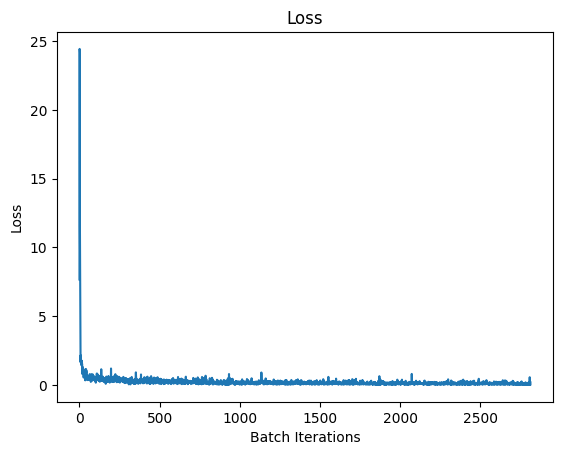

In [292]:
# Plot the loss over the course of training the model
plt.plot(losses)
plt.title("Loss")
plt.xlabel("Batch Iterations")
plt.ylabel("Loss")
plt.show()

In [294]:
def predict(x, params):
    layer_io = feed_forward(x, params)
    output = layer_io[-1].swapaxes(0,1)
    return output

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

# Check accuracy of the model using the test set
predictions = predict(x_test, final_parameters)
predictions = np.argmax(predictions, axis=1)
accuracy = get_accuracy(predictions, y_test)
print(f"Model has {accuracy} accuracy on test set.")
print(predictions[0:5], y_test[0:5])

0.9498
[7 2 1 0 4] [7 2 1 0 4]
